# **SOLAR ENERGY GENERATION MONITORING USING FUNDAMENTAL DATA STRUCTURES AND LIGHTWEIGHT MACHINE LEARNING TECHNIQUES**


---

**Problem Statement:**

    - Design a Python program to store, update, and analyze daily solar energy generation data of a small renewable energy plant.
    - The program should help a user (engineer/operator) record daily energy generation, view stored data, and perform basic analysis using fundamental data structures.


---

**Application Context (Renewable Energy):**

    1. A rooftop solar power plant records the daily energy generated (in kWh). This data is useful to:

    2. Monitor performance.

    3. Identify low-generation days.

    4. Compute average output.



---

**Data Structures to be Used:**

    Dictionary → Store date-wise energy generation

{
    
    "2026-01-01": 18.5,

    "2026-01-02": 21.3
}

    List → Store energy values for calculations



---

**Functional Requirements:**

    The program should provide a menu-driven system with the following options:

        1. Add daily solar energy generation.
        2. Display all stored generation data.
        3. Calculate total energy generated.
        4. Calculate average daily energy generation.
        5. Find the day with minimum energy generation.
        6. Exit the program.




---


# **1. REPRODUCIBILITY:**

In [20]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)

# **2. NECESSARY IMPORTS:**

In [21]:
from dataclasses import dataclass
from typing import List, Optional, Dict
from datetime import datetime, timedelta
from enum import Enum
import json
import logging

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.ensemble import IsolationForest

# **3. LOGGING CONFIGURATION:**

In [22]:
logging.basicConfig(
    filename="solar_monitor.log",
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)
logger = logging.getLogger(__name__)

# **4. ENUMS & DATA MODELS:**

In [23]:
class WeatherCondition(Enum):
    SUNNY = "Sunny"
    PARTLY_CLOUDY = "Partly Cloudy"
    CLOUDY = "Cloudy"
    STORMY = "Stormy"


@dataclass
class SolarReading:
    date: str
    energy_kwh: float
    temperature_c: Optional[float] = None
    weather: Optional[WeatherCondition] = None

    def __post_init__(self):
        if self.energy_kwh < 0:
            raise ValueError("Energy cannot be negative")

    def to_dict(self) -> Dict:
        return {
            "date": self.date,
            "energy_kwh": self.energy_kwh,
            "temperature_c": self.temperature_c,
            "weather": self.weather.value if self.weather else None
        }

# **5. CORE MONITORING LOGIC:**

In [24]:
class SolarEnergyMonitor:
    def __init__(self):
        self.readings: List[SolarReading] = []

    def add_reading(self, reading: SolarReading):
        self.readings.append(reading)
        logger.info(f"Added reading for {reading.date}")

    @property
    def total_energy(self) -> float:
        return sum(r.energy_kwh for r in self.readings)

    @property
    def average_daily_energy(self) -> float:
        if not self.readings:
            return 0.0
        return self.total_energy / len(self.readings)

    def detect_anomalies(self) -> List[Dict]:
        if len(self.readings) < 10:
            return []

        energies = np.array([r.energy_kwh for r in self.readings]).reshape(-1, 1)

        model = IsolationForest(contamination=0.1, random_state=42)
        preds = model.fit_predict(energies)

        anomalies = []
        for i, p in enumerate(preds):
            if p == -1:
                anomalies.append({
                    "date": self.readings[i].date,
                    "energy_kwh": self.readings[i].energy_kwh
                })
        return anomalies

# **6. VISUALIZATION UTILITIES (CLEAN, NON-COLLIDING):**

In [25]:
def plot_energy_with_anomalies(dates, energy, anomaly_indices):
    """
    Publication-quality plot with clear anomaly separation
    """
    plt.figure(figsize=(14, 6))

    plt.plot(
        dates,
        energy,
        linewidth=2,
        alpha=0.85,
        label="Daily Energy Generation",
        zorder=1
    )

    plt.scatter(
        [dates[i] for i in anomaly_indices],
        [energy[i] for i in anomaly_indices],
        color="red",
        s=90,
        edgecolors="black",
        linewidths=1,
        label="Detected Anomaly",
        zorder=3
    )

    plt.xlabel("Date")
    plt.ylabel("Energy Generated (kWh)")
    plt.title("Energy Generation with Detected Anomalies", weight="bold")

    plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45, ha="right")

    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

# **7. DEMONSTRATION DATA:**

In [26]:
def create_sample_data(days: int = 60) -> List[SolarReading]:
    base_date = datetime.now() - timedelta(days=days)
    data = []

    for i in range(days):
        date = (base_date + timedelta(days=i)).strftime('%Y-%m-%d')
        energy = 25 + np.random.normal(0, 5)

        if i in (15, 40):
            energy -= 12  # Inject anomalies

        data.append(
            SolarReading(
                date=date,
                energy_kwh=round(max(energy, 0), 1),
                weather=random.choice(list(WeatherCondition))
            )
        )
    return data

# **8. MAIN EXECUTION:**

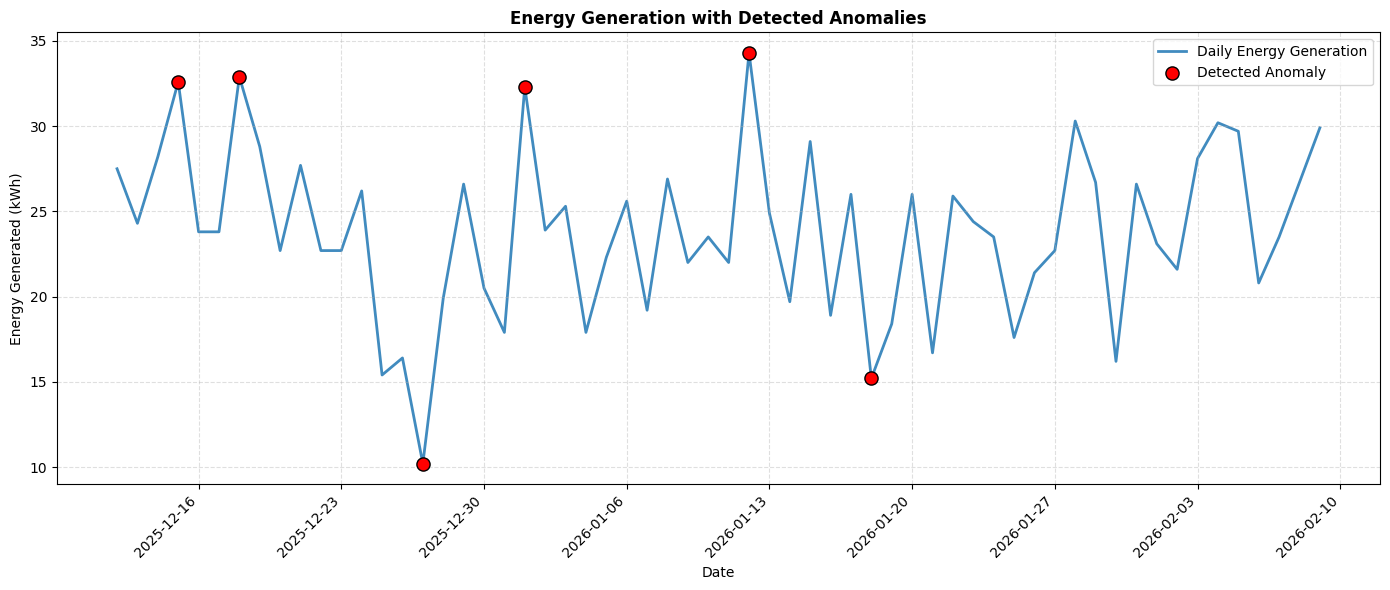

In [27]:
monitor = SolarEnergyMonitor()
sample_data = create_sample_data()

for r in sample_data:
    monitor.add_reading(r)

# Prepare data for plotting
dates = [datetime.strptime(r.date, "%Y-%m-%d") for r in monitor.readings]
energy = [r.energy_kwh for r in monitor.readings]

anomalies = monitor.detect_anomalies()
anomaly_indices = [
    i for i, r in enumerate(monitor.readings)
    if any(a['date'] == r.date for a in anomalies)
]

plot_energy_with_anomalies(dates, energy, anomaly_indices)

# **9. SUMMARY STATISTICS:**

In [28]:
print("\nSummary Statistics")
print("------------------")
print(f"Total Energy: {monitor.total_energy:.2f} kWh")
print(f"Average Daily Energy: {monitor.average_daily_energy:.2f} kWh")
print(f"Anomalies Detected: {len(anomalies)}")


Summary Statistics
------------------
Total Energy: 1429.80 kWh
Average Daily Energy: 23.83 kWh
Anomalies Detected: 6
